In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pickle
import os

from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [2]:
PCT_DATA = .2
N_VOCAB = 500

In [3]:
def rm_stop(words):
    new_words = []
    stop_words = nltk.corpus.stopwords.words('english')

    for w in words:
        if w not in stop_words:
            new_words.append(w)
    return new_words

def build_data(pct_data=PCT_DATA):
    raw_df = pd.read_csv('data/finaldataset.csv')
    raw_df = raw_df.iloc[:round(raw_df.shape[0] * pct_data)]

    df = raw_df[['num_comments', 'title']]
    del raw_df

    df.loc[:,'title'] = df['title'].str.lower()
    tokenizer = nltk.RegexpTokenizer(r'\b[(a-z)]+\b')

    df.loc[:,'tokenized'] = df['title'].apply(tokenizer.tokenize)

    df['tokenized'] = df['tokenized'].apply(rm_stop)
    df['text'] = df['tokenized'].apply(lambda x: ' '.join([word for word in x]))

    return df

def fit_n_vocab(df, n_vocab=N_VOCAB):
    vectorizer = CountVectorizer(max_features=n_vocab)
    vecfit = vectorizer.fit_transform(df['text'])
    X = vecfit.toarray()

    vocab = vectorizer.get_feature_names_out()
    Y = df['num_comments'].to_numpy()

    return X, Y, vocab, vectorizer 

def pct_no_words(X):
    return sum(np.sum(X, axis=1) > 0)/X.shape[0]

def pred_from_str(q, m, vec):
    tokenizer = nltk.RegexpTokenizer(r'\b[(a-z)]+\b')

    q = tokenizer.tokenize(q)
    q = rm_stop(q)

    j = lambda x: ' '.join([word for word in x])
    q = j(q)
    pred_X = vec.transform(pd.Series(q)).toarray()

    pred = m.predict(pred_X)

    return pred

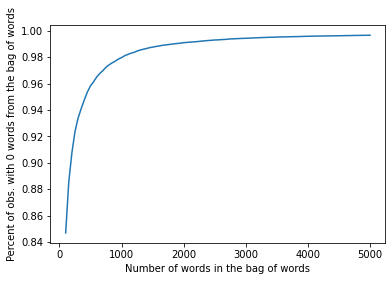

In [4]:
# set run = True if first time running, False otherwise as it takes a while to run
run = False

if run:
    pct_vals = []
    df = build_data()

    for i in tqdm(np.arange(100, 5001, 50)):
        X = fit_n_vocab(df=df, n_vocab=i)[0]
        pct = pct_no_words(X)
        pct_vals.append([i, pct])
    pct_df = pd.DataFrame(pct_vals, columns=['n_vocab', 'pct_words'])
    pct_df.to_csv('pct_df.csv')
else:
    pct_df = pd.read_csv('pct_df.csv')

plt.plot(pct_df['n_vocab'], pct_df['pct_words'])
plt.xlabel('Number of words in the bag of words')
plt.ylabel('Percent of obs. with 0 words from the bag of words')

plt.show()

In [5]:
df = build_data()
X, Y, vocab, vectorizer = fit_n_vocab(df=df, n_vocab=N_VOCAB)


# Y transformation
Y = np.log(Y, dtype=float)

del df

C:\Users\Sean\AppData\Local\Temp\ipykernel_6796\3770191541.py:11: DtypeWarning: Columns (7,8,61,62,66,67,70,71,72,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('data/finaldataset.csv')


In [7]:
import statsmodels.api as sm

ols = sm.OLS(Y, X)
ols_fit = ols.fit()

# https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe
vocab_coeff_df = pd.DataFrame({'word': vocab, 'coeff': ols_fit.params, 'pval': ols_fit.pvalues})

In [8]:
vocab_coeff_df.sort_values('coeff', ascending=False)

,word,coeff,pval
457,username,1.928780,1.475911e-166
311,overrated,1.544732,5.037944e-123
431,thoughts,1.476070,7.884667e-265
281,miss,1.472854,4.332986e-89
142,favourite,1.465377,0.000000e+00
...,...,...,...
487,workers,-0.183377,1.110874e-02
21,another,-0.227204,3.113206e-05
235,later,-0.239520,1.290572e-03
11,also,-0.289875,1.097669e-05


In [9]:
from xgboost import XGBRegressor

xgbr = XGBRegressor()
xgbr.fit(X, Y)

C:\Users\Sean\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [10]:
xgbr.predict(X)

array([2.5224602, 2.409966 , 2.3532548, ..., 2.5376554, 2.0632293,
       2.4864795], dtype=float32)

In [11]:
from sklearn.metrics import mean_squared_error

print(f'MSE of boosted trees: {mean_squared_error(Y, xgbr.predict(X))}')
print(f'MSE of OLS: {mean_squared_error(Y, ols_fit.predict(X))}')

MSE of boosted trees: 0.6835865692916593
MSE of OLS: 2.3667065173603503


In [12]:
qs = 'what if thankfully whos username?'
print(np.exp(pred_from_str(qs, xgbr, vectorizer)))
print(np.exp(pred_from_str(qs, ols_fit, vectorizer)))

[24.819849]
[6.88111027]
